# test lseg's ability to detect wall/room
- form vlmap, index with 'room'/'bedroom'/'livingroom'/'kitchen'/'bathroom'/'corridor'/'balcony'/'other'
- directly index image, then

In [1]:
import matplotlib.pyplot as plt
def draw_hist(pc):
    # 绘制直方图
    plt.hist(pc, bins=30, alpha=0.75, color='blue', edgecolor='black')

    # 添加标题和标签
    plt.title('Data Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # 显示图像
    plt.show()

In [ ]:

map_path = '/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7_1/vlmap_cam/vlmaps_cam.h5df'
import matplotlib.pyplot as plt

import numpy as np
mask = np.load('scored_list.npy')


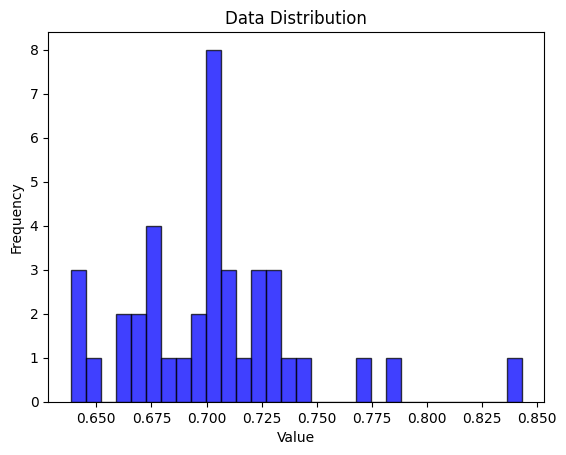

In [3]:
# 计算每一行的最大值
vector_eg = mask[0]
draw_hist(vector_eg)


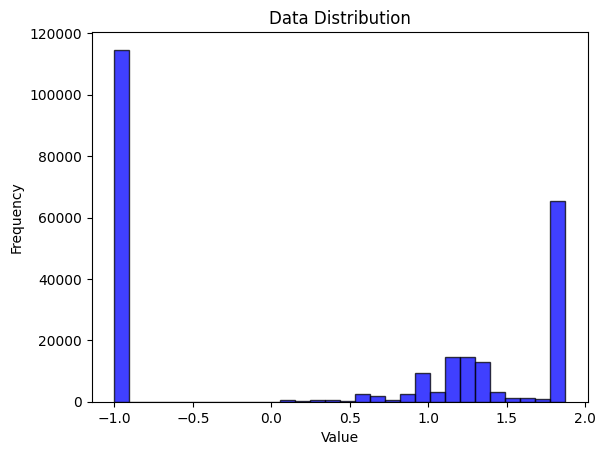

In [24]:
import numpy as np
mask = np.load('depth_npy.npy')
# 将所有 inf 值替换为 -1
mask[mask == np.inf] = -1
mask_dist = mask.flatten()
draw_hist(mask_dist)

In [28]:
min_height = 0
max_height = 1.7775
# mask >=min_height and mask < max_height and mask == inf 的为obstacle
depth_mask = (mask >= min_height) & (mask < max_height)

# visualize depth_mask using cv2
import cv2

def plot_2d_bool(depth_mask):
    # 将布尔掩码转换为uint8类型
    depth_mask_uint8 = depth_mask.astype(np.uint8) * 255

    # 创建伪彩色图像
    depth_colormap = cv2.applyColorMap(depth_mask_uint8, cv2.COLORMAP_JET)

    # 显示图像
    plt.figure(figsize=(10,8))
    plt.imshow(cv2.cvtColor(depth_colormap, cv2.COLOR_BGR2RGB))
    plt.colorbar()
    plt.title('深度图可视化')
    plt.show()


/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28145 (\N{CJK UNIFIED IDEOGRAPH-6DF1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21487 (\N{CJK UNIFIED IDEOGRAPH-53EF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/site-packages/IPython/core/pylabtools.py:15

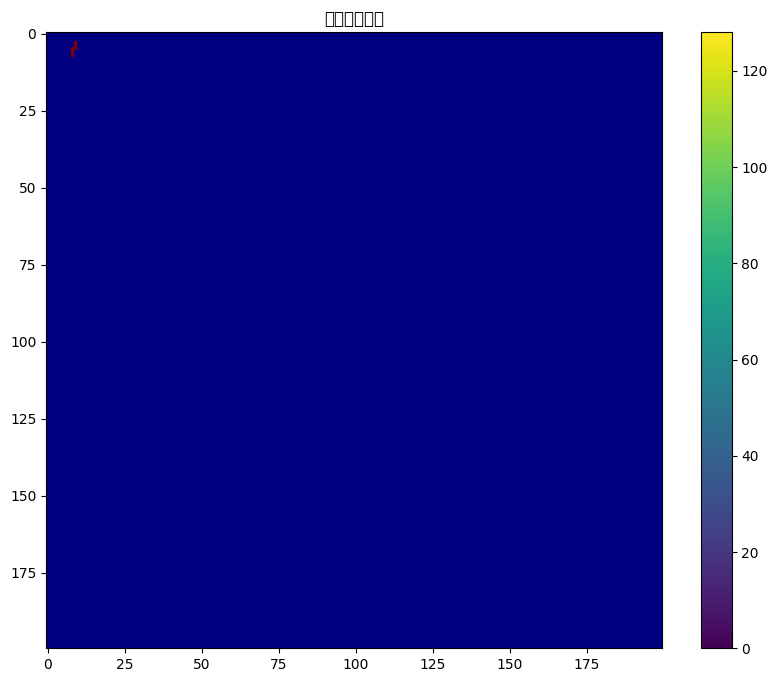

In [32]:
mask = np.load('pc_mask.npy')
mask.shape
plot_2d_bool(mask)

In [ ]:

def get_surrounding_free_map(self, robot_pos, robot_height=1.05+0.8, update_camera_pose=False, verbose=True):
        # Define height range for free map
        # free_map: 1 for free space, 0 for occupied space

        min_height = 0
        max_height = self.isaac_camera.get_world_pose()-robot_height
        normal_threshold = 0.005

        # rgb_init, depth_init, mask, (row_min, row_max), (col_min, col_max), pointcloud = self._get_topdown_map(self.topdown_camera)

        # get info
        data_info = self.get_camera_data()
        rgb = np.array(data_info["rgba"])
        depth = np.array(data_info["depth"])

        # Generate mask for depth within the acceptable range
        depth_mask = (depth >= min_height) & (depth < max_height)

        # robot_mask
        robot_mask = self.create_robot_mask()

        # Combine masks to determine free space
        free_map = np.zeros_like(depth, dtype=int)
        free_map[depth_mask] = 1  # Free space is where conditions are met
        free_map[robot_mask == 1] = 1  # Robot's location is free space

        if verbose:
            img = Image.fromarray(rgb)
            if os.path.exists(self.args.log_image_dir+"/cam_free") == False:
                os.makedirs(self.args.log_image_dir+"/cam_free")
            img_path = os.path.join(self.args.log_image_dir, "cam_free","rgb_scene_local.png")
            img.save(img_path)
            # print("Image saved at", img_path)

            depth_img = self.vis_depth(depth, robot_height)
            depth_img_path = os.path.join(self.args.log_image_dir, "cam_free", "depth_scene_local.png")
            depth_img.save(depth_img_path)
            # print("Depth saved at", depth_img_path)
        
            # Visualize the free map
            free_map_normalized = free_map.astype(bool)
            # free_map_normalized = ((free_map - free_map.min()) * (1/(free_map.max() - free_map.min()) * 255)).astype('uint8')
            free_map_image = Image.fromarray(free_map_normalized)
            # Save the image
            free_map_path = os.path.join(self.args.log_image_dir, "cam_free", "topdown_local_freemap.png")
            free_map_image.save(free_map_path)
            # print("Free map saved at", free_map_path)
        
        # extract connectd free area
        connected_free_area = self.extract_connected_free_area(free_map, verbose=verbose)

        if update_camera_pose:
            # update the pose of the camera based on robot's pose
            self.issac_camera.set_world_pose([robot_pos[0], robot_pos[1], robot_pos[2]+0.8])

        return free_map, connected_free_area


In [17]:
from pathlib import Path
import hydra
from omegaconf import DictConfig
import sys, os
print(sys.path)
from vlmaps.vlmaps.map.vlmap import VLMap
from vlmaps.vlmaps.utils.matterport3d_categories import mp3dcat
from vlmaps.vlmaps.utils.visualize_utils import (
    pool_3d_label_to_2d,
    pool_3d_rgb_to_2d,
    visualize_rgb_map_3d,
    visualize_masked_map_2d,
    visualize_heatmap_2d,
    visualize_heatmap_3d,
    visualize_masked_map_3d,
    get_heatmap_from_mask_2d,
    get_heatmap_from_mask_3d,
)

import types
import numpy as np

# 原始字典
map_config = {
    'map_type': 'IsaacSimMap',
    'pose_info': {
        'pose_type': 'camera_base',
        'rot_type': 'quat',
        'camera_height': 1.5,
        'base2cam_rot': [1, 0, 0, 0, -1, 0, 0, 0, -1],
        'base_forward_axis': [0, 0, -1],
        'base_left_axis': [-1, 0, 0],
        'base_up_axis': [0, 1, 0]
    },
    'skip_frame': 1,
    'cam_calib_mat': [221, 0, 128, 0, 221, 128, 0, 0, 1],
    'grid_size': '${params.gs}',
    'cell_size': '${params.cs}',
    'robot_z': '${params.robot_z}',
    'depth_sample_rate': 50,
    'dilate_iter': 3,
    'gaussian_sigma': 1.0,
    'customize_obstacle_map': False,
    'potential_obstacle_names': ['wall', 'floor', 'chair', 'door', 'table', 'picture', 'cabinet', 'cushion', 'window', 'sofa', 'bed', 'curtain', 'chest_of_drawers', 'plant', 'sink', 'stairs', 'ceiling', 'toilet', 'stool', 'towel', 'mirror', 'tv_monitor', 'shower', 'column', 'bathtub', 'counter', 'fireplace', 'lighting', 'beam', 'railing', 'shelving', 'blinds', 'gym_equipment', 'seating', 'board_panel', 'furniture', 'appliances', 'clothes', 'objects'],
    'obstacle_names': ['wall', 'floor', 'chair', 'door', 'table', 'picture', 'cabinet', 'cushion', 'window', 'sofa', 'bed', 'curtain', 'chest_of_drawers', 'plant', 'sink', 'stairs', 'ceiling', 'toilet', 'stool', 'towel', 'mirror', 'tv_monitor', 'shower', 'column', 'bathtub', 'counter', 'fireplace', 'lighting', 'beam', 'railing', 'shelving', 'blinds', 'gym_equipment', 'seating', 'board_panel', 'furniture', 'appliances', 'clothes', 'objects'],
    'categories': 'mp3d'
}

# 将字典转换为 SimpleNamespace 对象
map_config_ns = types.SimpleNamespace(**map_config)
map_config_ns.pose_info = types.SimpleNamespace(**map_config_ns.pose_info)

# 示例使用
self = types.SimpleNamespace()
self.map_config = map_config_ns
self.base2cam_tf = np.zeros((3, 3))  # 假设 self.base2cam_tf 是一个 3x3 的矩阵

# 访问并设置属性
self.base2cam_tf[:3, :3] = np.array(self.map_config.pose_info.base2cam_rot).reshape((3, 3))

# vlmap_save_path =  '/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7_1/'
# vlmap_save_path = '/ssd/xiaxinyuan/code/w61-grutopia/logs_docker/7y3sRwLe3Va/id_7/'
vlmap_save_path = '/ssd/xiaxinyuan/code/w61-grutopia/logs_docker/mJXqzFtmKg4/id_32/'
# vlmap_save_path ='/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7/id_5/'
vlmap = VLMap(self.map_config, data_dir= vlmap_save_path)
vlmap.load_map(vlmap_save_path)


['/home/xiaxinyuan/.conda/envs/isaacsim/lib/python310.zip', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/lib-dynload', '', '/home/xiaxinyuan/.local/lib/python3.10/site-packages', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/site-packages', '__editable__.omni_isaac_lab-0.22.1.finder.__path_hook__', '__editable__.omni_isaac_lab_assets-0.1.3.finder.__path_hook__', '__editable__.omni_isaac_lab_tasks-0.10.0.finder.__path_hook__', '/ssd/xiaxinyuan/code/w61-grutopia', '/home/xiaxinyuan/Hierarchical-Localization', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/site-packages/setuptools/_vendor']
/ssd/xiaxinyuan/code/w61-grutopia/logs_docker/mJXqzFtmKg4/id_32
/ssd/xiaxinyuan/code/w61-grutopia/logs_docker/mJXqzFtmKg4/id_32/vlmap_cam/vlmaps_cam.h5df


True

In [23]:
import cv2
import matplotlib.pyplot as plt
def display_image_in_notebook(image_path):
    # 读取图像
    image = cv2.imread(image_path)
    
    # 检查图像是否成功读取
    if image is None:
        print(f"Failed to load image from {image_path}")
        return
    
    # 将图像从 BGR 转换为 RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 在 Jupyter Notebook 中显示图像
    plt.imshow(image_rgb)
    plt.axis('off')  # 关闭坐标轴
    plt.show()


vlmap._init_clip()
cat = 'kitchen'
gs =200
cs = 0.1
decay_rate = 0.02


clip model is already initialized


In [19]:
def visualize_2d(cat,mask):
    # init categories with cat and other:
    mask = vlmap.index_map(cat, with_init_cat=False,threshold=0)
    mask_2d = pool_3d_label_to_2d(mask, vlmap.grid_pos, gs)
    rgb_2d = pool_3d_rgb_to_2d(vlmap.grid_rgb, vlmap.grid_pos, gs)

    print(vlmap.map_save_path)

    save_path = Path(vlmap_save_path) /'vlmap_cam'/ f"{cat}_masked_2d_binary.jpg"
    visualize_masked_map_2d(rgb_2d, mask_2d, save_path = save_path)
    display_image_in_notebook(save_path)

    heatmap = get_heatmap_from_mask_2d(mask_2d, cell_size=cs, decay_rate=decay_rate)
    save_path = Path(vlmap_save_path)/'vlmap_cam'/ f"{cat}_heatmap_2d_binary.jpg"
    visualize_heatmap_2d(rgb_2d, heatmap,save_path=save_path)
    display_image_in_notebook(save_path)

def visualize_3d(cat, mask):
    save_path = f'{vlmap_save_path}/vlmap_cam/{cat}_masked_3d_binary.pcd'
    visualize_masked_map_3d(vlmap.grid_pos, mask, vlmap.grid_rgb, save_path = save_path)
    heatmap = get_heatmap_from_mask_3d(
            vlmap.grid_pos, mask, cell_size=cs, decay_rate=decay_rate
        )
    save_path = f'{vlmap_save_path}/vlmap_cam/{cat}_heatmap_3d_binary.pcd'
    visualize_heatmap_3d(vlmap.grid_pos, heatmap, vlmap.grid_rgb, save_path = save_path)


In [26]:
vlmap.grid_pos.shape

(17579, 3)

In [25]:
vlmap.scores_mat
draw_hist(vlmap.scores_mat[1])


NameError: name 'draw_hist' is not defined

In [34]:
np.sum(mask)

35

wall,floor,chair,door,table,picture,cabinet,cushion,window,sofa,bed,curtain,chest_of_drawers,plant,sink,stairs,ceiling,toilet,stool,towel,mirror,tv_monitor,shower,column,bathtub,counter,fireplace,lighting,beam,railing,shelving,blinds,gym_equipment,seating,board_panel,furniture,appliances,clothes
sofa
Image saved to tmp/living_room_masked_2d.jpg


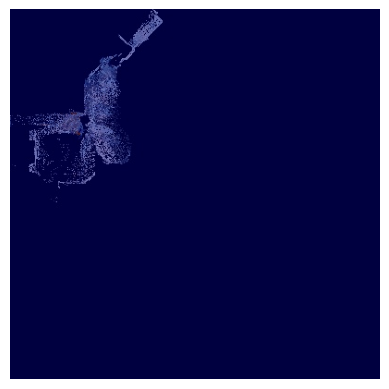

Image saved to tmp/living_room_heatmap_2d.jpg


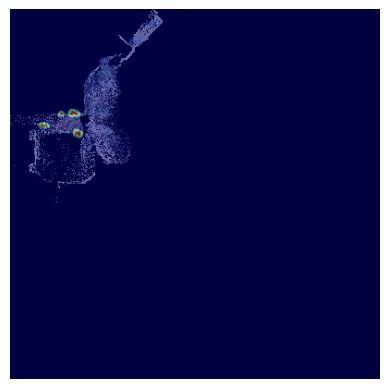

In [33]:
cat = 'living_room'
vlmap.init_categories(mp3dcat[1:-1])
mask = vlmap.index_map(cat, with_init_cat=True)

mask_2d = pool_3d_label_to_2d(mask, vlmap.grid_pos, gs*2)
rgb_2d = pool_3d_rgb_to_2d(vlmap.grid_rgb, vlmap.grid_pos, gs*2)
save_path = 'tmp/' + f"{cat}_masked_2d.jpg"
visualize_masked_map_2d(rgb_2d, mask_2d,save_path=save_path)
display_image_in_notebook(save_path)


heatmap = get_heatmap_from_mask_2d(mask_2d, cell_size=cs, decay_rate=decay_rate)
save_path = 'tmp/' +  f"{cat}_heatmap_2d.jpg"
visualize_heatmap_2d(rgb_2d, heatmap,save_path=save_path)
display_image_in_notebook(save_path)


In [15]:
a = [1,2,3]
b = [1,2]

a.append(b)
print(a)

[1, 2, 3, [1, 2]]


In [42]:

max_idx = np.argmax(vlmap.scores_mat, axis=1)
topdown_mask = np.zeros([200,200]).astype(int)
for pos,lbl in zip(vlmap.grid_pos,max_idx):
   topdown_mask[pos[0],pos[1]] = int(lbl+1)



from vlmaps.vlmaps.utils.mapping_utils import get_new_mask_pallete,get_new_pallete
# labels: ['null', other labels in mp3d]

labels = mp3dcat


In [44]:

new_palette = get_new_pallete(len(labels))
mask, patches = get_new_mask_pallete(topdown_mask, new_palette, out_label_flag=True, labels=labels)
seg = mask.convert("RGBA")

# 创建图像和分割结果的子图
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(seg)
ax.set_title("Segmentation Result")
ax.axis("off")

# 创建图例
legend_fig, legend_ax = plt.subplots(figsize=(15, 2))
legend_ax.legend(handles=patches, loc="center", ncol=10, prop={"size": 10})
legend_ax.axis("off")

# 保存图像和图例
plt.tight_layout()
fig.savefig('segmentation_result.jpg', bbox_inches='tight')
legend_fig.savefig('segmentation_legend.jpg', bbox_inches='tight')

# 关闭图形以释放内存
plt.close(fig)
plt.close(legend_fig)

<BarContainer object of 10 artists>

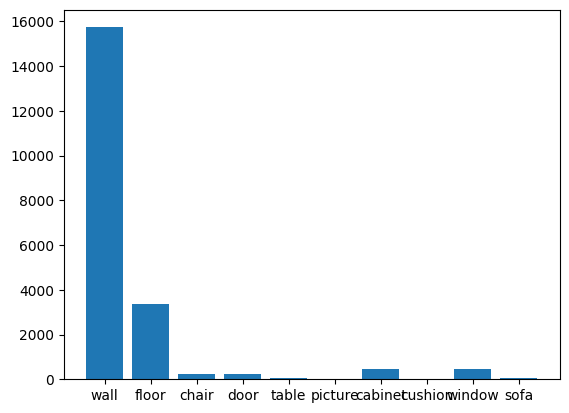

In [15]:

max_values = np.max(mask, axis=1)

# 计算每一行最大值对应的索引
max_indices = np.argmax(mask, axis=1)

# draw_hist(max_values)

from vlmaps.vlmaps.utils.matterport3d_categories import mp3dcat
indexed_dict = mp3dcat[1:]

sum_of_idx = np.zeros(len(indexed_dict))
for i in max_indices:
    sum_of_idx[i] += 1

plt.bar(indexed_dict[:10], sum_of_idx[:10])


<BarContainer object of 10 artists>

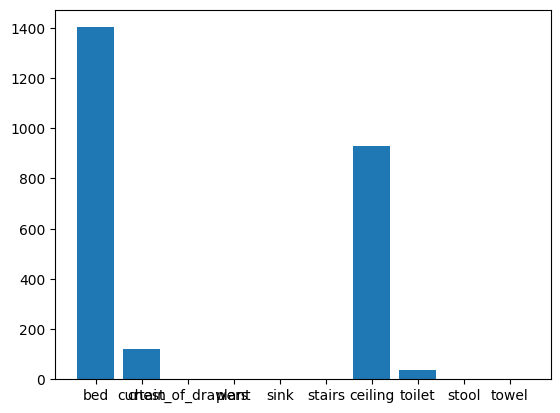

In [16]:


plt.bar(indexed_dict[10:20], sum_of_idx[10:20])


['mirror', 'tv_monitor', 'shower', 'column', 'bathtub', 'counter', 'fireplace', 'lighting', 'beam', 'railing', 'shelving', 'blinds', 'gym_equipment', 'seating', 'board_panel', 'furniture', 'appliances', 'clothes', 'objects']


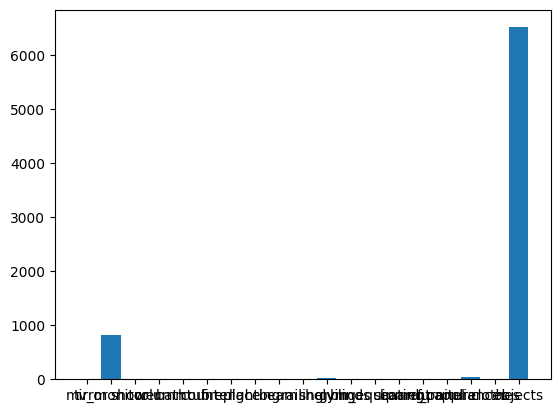

In [18]:


plt.bar(indexed_dict[20:], sum_of_idx[20:])
print(indexed_dict[20:])



# Instruction Tuning

In [ ]:
from vlmaps.vlmaps.utils.llm_utils import parse_spatial_instruction

import os
import json
def read_instructions_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    print(f"Instructions read from {file_path}")
    return data

# 使用示例
file_path = 'tmp/instructions.json'
instructions = read_instructions_from_file(file_path)

parse_spatial_instruction(instructions[0]['instruction'])
# # 通过索引访问数据
# for instruction in instructions:
#     print(f"Idx: {instruction['idx']}, Instruction: {instruction['instruction']}")


In [4]:
from vlmaps.vlmaps.utils.index_utils import find_similar_category_id
from vlmaps.vlmaps.utils.matterport3d_categories import mp3dcat
find_similar_category_id('kitchen', mp3dcat)


void,wall,floor,chair,door,table,picture,cabinet,cushion,window,sofa,bed,curtain,chest_of_drawers,plant,sink,stairs,ceiling,toilet,stool,towel,mirror,tv_monitor,shower,column,bathtub,counter,fireplace,lighting,beam,railing,shelving,blinds,gym_equipment,seating,board_panel,furniture,appliances,clothes,objects
cabinet


7

In [ ]:
import gzip
import json
import copy
import os
starrt_pos_dict = {}
instruction_list = []
def load_data(split):
    ''' Load data based on VLN-CE
    '''
    # dataset_root_dir = base_data_dir # '../VLN/VLNCE/R2R_VLNCE_v1-3'
    dataset_root_dir = '/ssd/xiaxinyuan/code/VLN/VLNCE/R2R_VLNCE_v1-3'
    total_scans = []
    load_data = []
    with gzip.open(os.path.join(dataset_root_dir, f"{split}", f"{split}.json.gz"), 'rt', encoding='utf-8') as f:
        data = json.load(f)
        for item in data["episodes"]:
            
            name = os.path.splitext(os.path.basename(item['scene_id']))[0]
            start_position = item['instruction']['instruction_text']
            print(name,item['episode_id'], item['trajectory_id'],start_position)
            instruction_list.append({'idx':name,'instruction':start_position})
            # item["original_start_position"] = copy.copy(item["start_position"])
            # item["original_start_rotation"] = copy.copy(item["start_rotation"])
            # item["start_position"] = [item["original_start_position"][0], -item["original_start_position"][2], item["original_start_position"][1]]
            # item["start_rotation"] = [-item["original_start_rotation"][3], item["original_start_rotation"][0], item["original_start_rotation"][2], -item["original_start_rotation"][1]] # [x,y,z,-w] => [w,x,y,z]
            # item["scan"] = item["scene_id"].split("/")[1]
            # item["c_reference_path"] = []
            # if "reference_path" in item.keys():
            #     for path in item["reference_path"]:
            #         item["c_reference_path"].append([path[0], -path[2], path[1]])
            #     item["reference_path"] = item["c_reference_path"]
            #     del item["c_reference_path"]
            # load_data.append(item)
            # total_scans.append(item["scan"])

    # return load_data, list(set(total_scans))

# splits = ['train', 'val_seen', 'val_unseen', 'test']
splits = ['train']
for split in splits:
    load_data(split)

# def save_dict_to_file(data, file_path):
#     with open(file_path, 'w', encoding='utf-8') as file:
#         json.dump(data, file, ensure_ascii=False, indent=4)
#     print(f"Dictionary saved to {file_path}")
# file_path = 'tmp/instructions.json'
# save_dict_to_file(instruction_list, file_path)


In [3]:
import json
json_file = '/ssd/share/vlmap/vlmaps_dataset/5LpN3gDmAk7_1/spatial_goal_navigation_tasks.json'
with open(json_file, 'r', encoding='utf-8') as file:
    data = json.load(file)
    print(f"Instructions read from {json_file}")


Instructions read from /ssd/share/vlmap/vlmaps_dataset/5LpN3gDmAk7_1/spatial_goal_navigation_tasks.json


In [16]:
data[0]['instruction']


'move first to the left side of the counter in front of you, face the counter and then move to the west of the counter, later, with the counter on your right, go to the east of the chair in front of you, and finally move to the sofa in front of you.'

In [4]:
from vlmaps.vlmaps.utils.llm_utils import parse_spatial_instruction
parse_spatial_instruction(data[0]['instruction'])


"```python\nself.move_to_left('counter')\nself.face('counter')\nself.move_west('counter')\nself.with_object_on_right('counter')\nself.move_east('chair')\nself.move_to_object('sofa')\n```"

In [7]:
test_str = 'for i in range(10):\n print(i)'
exec(test_str)


0
1
2
3
4
5
6
7
8
9


In [8]:
import re

def extract_self_methods(input_string):
    """
    从输入字符串中提取以 `self.` 开头的所有部分，并放到一个列表中
    :param input_string: 输入字符串
    :return: 提取的部分列表
    """
    # 使用正则表达式匹配以 `self.` 开头的部分
    matches = re.findall(r'self\.\w+\(.*?\)', input_string)
    return matches

# 示例输入
input_string = "python\nself.move_to_left('counter')\nself.face('counter')\nself.move_west('counter')\nself.with_object_on_right('counter')\nself.move_east('chair')\nself.move_to_object('sofa')\n"

# 提取以 `self.` 开头的部分
extracted_methods = extract_self_methods(input_string)

# 打印结果
print(extracted_methods)


["self.move_to_left('counter')", "self.face('counter')", "self.move_west('counter')", "self.with_object_on_right('counter')", "self.move_east('chair')", "self.move_to_object('sofa')"]


In [ ]:
pcd_global = o3d.geometry.PointCloud()
pcd_global.points = o3d.utility.Vector3dVector(pc_filtered)
visualize_pc(pcd_global, headless = True)


In [ ]:
# get camera:
self.env._runner.current_tasks[self.task_name].robots[self.robot_name].sensors['pano_camera_0'].get_world_pose()
rgb = self.topdown_camera.get_data()["rgba"] # topdown_camera: grutopia_camera
cv2.imwrite('panp_rgb.jpg',rgb)

# get curr pos
self.issac_camera.get_world_pose()


# filter the threads
total num(without stairs): 'train':8158, 'val_seen': 559, 'val_unseen': 1284, 'test': 2364

ignore all episodes with 'stairs' in the instruction and separate them into multiple 
numpy arrays

write a function with input 

n: number of gpus to distribute the data

dataset_root_dir: the root directory of the dataset

first calculate by trajectory_id, then by episode_id


In [2]:
import gzip
import json
import copy
import os
starrt_pos_dict = {}
episode_id = []
def load_data(split):
    ''' Load data based on VLN-CE
    '''
    # dataset_root_dir = base_data_dir # '../VLN/VLNCE/R2R_VLNCE_v1-3'
    dataset_root_dir = '/ssd/xiaxinyuan/code/VLN/VLNCE/R2R_VLNCE_v1-3'
    instruction_list = []
    total_scans = []
    load_data = []
    with gzip.open(os.path.join(dataset_root_dir, f"{split}", f"{split}.json.gz"), 'rt', encoding='utf-8') as f:
        data = json.load(f)
        for item in data["episodes"]:
            if ('stairs' in item['instruction']['instruction_text']):
                continue
            name = os.path.splitext(os.path.basename(item['scene_id']))[0]
            # start_position = item['instruction']['instruction_text']
            start_position = item['start_position']
            print(name,item['episode_id'], item['trajectory_id'],start_position)
            instruction_list.append({'idx':name,'instruction':start_position})
            # item["original_start_position"] = copy.copy(item["start_position"])
            # item["original_start_rotation"] = copy.copy(item["start_rotation"])
            # item["start_position"] = [item["original_start_position"][0], -item["original_start_position"][2], item["original_start_position"][1]]
            # item["start_rotation"] = [-item["original_start_rotation"][3], item["original_start_rotation"][0], item["original_start_rotation"][2], -item["original_start_rotation"][1]] # [x,y,z,-w] => [w,x,y,z]
            # item["scan"] = item["scene_id"].split("/")[1]
            # item["c_reference_path"] = []
            # if "reference_path" in item.keys():
            #     for path in item["reference_path"]:
            #         item["c_reference_path"].append([path[0], -path[2], path[1]])
            #     item["reference_path"] = item["c_reference_path"]
            #     del item["c_reference_path"]
            # load_data.append(item)
            # total_scans.append(item["scan"])
    return instruction_list
    # return load_data, list(set(total_scans))

# splits = ['train', 'val_seen', 'val_unseen', 'test']
# splits = ['train']
splits = ['val_seen']
for split in splits:
    instruction_list = load_data(split)
    print(len(instruction_list))
# def save_dict_to_file(data, file_path):
#     with open(file_path, 'w', encoding='utf-8') as file:
#         json.dump(data, file, ensure_ascii=False, indent=4)
#     print(f"Dictionary saved to {file_path}")
# file_path = 'tmp/instructions.json'
# save_dict_to_file(instruction_list, file_path)


E9uDoFAP3SH 4 93 [13.333499908447266, 0.24438095092773438, 5.276130199432373]
E9uDoFAP3SH 5 93 [13.333499908447266, 0.24438095092773438, 5.276130199432373]
E9uDoFAP3SH 6 93 [13.333499908447266, 0.24438095092773438, 5.276130199432373]
r1Q1Z4BcV1o 7 111 [-9.448829650878906, 0.07537198066711426, -0.8151869773864746]
r1Q1Z4BcV1o 9 111 [-9.448829650878906, 0.07537198066711426, -0.8151869773864746]
759xd9YjKW5 10 139 [-7.182509899139404, 0.09666500240564346, 21.212299346923828]
759xd9YjKW5 11 139 [-7.182509899139404, 0.09666500240564346, 21.212299346923828]
759xd9YjKW5 12 139 [-7.182509899139404, 0.09666500240564346, 21.212299346923828]
sT4fr6TAbpF 13 149 [-0.9836609959602356, 0.05631500482559204, 3.532670021057129]
sT4fr6TAbpF 14 149 [-0.9836609959602356, 0.05631500482559204, 3.532670021057129]
sT4fr6TAbpF 15 149 [-0.9836609959602356, 0.05631500482559204, 3.532670021057129]
JeFG25nYj2p 16 180 [-2.485460042953491, 0.09358400106430054, 4.0524702072143555]
JeFG25nYj2p 17 180 [-2.48546004295349

In [23]:
import gzip
import json
import copy
import os
starrt_pos_dict = {}
episode_id = []
trajectory_id_list = []
def get_sub_trajectory_id_list():
    with open('vlmaps/docker/valid_paths/success_paths_id_all.txt', 'r') as f:
        sub_trajectory_id_list = [int(line.strip()) for line in f.readlines()]
        # 重新按大小排序
        sub_trajectory_id_list.sort()
    return sub_trajectory_id_list


def find_gpu_id(trajectory_id,num_of_gpus,trajectory_id_list):
    for idx, id in enumerate(trajectory_id_list):
        if (id == trajectory_id):
            return idx % num_of_gpus
def judge_stair_exists(path):
    '''
    path_z: ndarray, if max(path_z)- min(path_z) > 1.5, then there is a stair
    '''
    path_z = []
    for path in path:
        path_z.append(path[1])
    return max(path_z)- min(path_z) > 1.5

def load_data(split,num_of_gpus):
    ''' Load data based on VLN-CE
    '''
    # dataset_root_dir = base_data_dir # '../VLN/VLNCE/R2R_VLNCE_v1-3'
    dataset_root_dir = '/ssd/xiaxinyuan/code/VLN/VLNCE/R2R_VLNCE_v1-3'
    scene_id_list = []
    total_scans = []
    load_data = []
    split_data = [[] for _ in range(num_of_gpus)]
    trajectory_id_list = get_sub_trajectory_id_list()
    print(len(trajectory_id_list))
    for split in splits:
            with gzip.open(os.path.join(dataset_root_dir, f"{split}", f"{split}.json.gz"), 'rt', encoding='utf-8') as f:
                data = json.load(f)
            for item in data["episodes"]:
                scene_id = item['scene_id'].split('/')[1]
                if scene_id not in scene_id_list:
                    scene_id_list.append(scene_id)
            for item in data["episodes"]:
                if not judge_stair_exists(item['reference_path'])  and (item['trajectory_id'] in trajectory_id_list):

                    scene_id = item['scene_id'].split('/')[1]
                    gpu_id = find_gpu_id(scene_id, num_of_gpus, scene_id_list)
                    split_data[gpu_id].append((scene_id,item['trajectory_id'],item['episode_id']))
                    print(scene_id,item['trajectory_id'],item['episode_id'])

    # sort the split_data by the scene_id
    for i in range(num_of_gpus):
        split_data[i].sort(key=lambda x: x[0])
    return split_data
    # return load_data, list(set(total_scans))
# splits = ['train', 'val_seen', 'val_unseen', 'test']
splits = ['train']
# splits = ['val_seen']
# splits = ['val_seen']
num_of_gpus = 4
for split in splits:
    split_data = load_data(split,num_of_gpus)
    print(split_data)



715
7y3sRwLe3Va 4 1
7y3sRwLe3Va 4 2
7y3sRwLe3Va 4 3
5LpN3gDmAk7 5 4
5LpN3gDmAk7 5 5
5LpN3gDmAk7 5 6
7y3sRwLe3Va 6 7
7y3sRwLe3Va 6 8
7y3sRwLe3Va 6 9
EDJbREhghzL 19 28
EDJbREhghzL 19 29
EDJbREhghzL 19 30
mJXqzFtmKg4 22 31
mJXqzFtmKg4 22 32
mJXqzFtmKg4 22 33
pRbA3pwrgk9 23 34
pRbA3pwrgk9 23 35
pRbA3pwrgk9 23 36
ur6pFq6Qu1A 27 43
ur6pFq6Qu1A 27 44
ur6pFq6Qu1A 27 45
ur6pFq6Qu1A 34 49
ur6pFq6Qu1A 34 50
ur6pFq6Qu1A 34 51
8WUmhLawc2A 48 67
8WUmhLawc2A 48 68
8WUmhLawc2A 48 69
i5noydFURQK 56 70
i5noydFURQK 56 71
i5noydFURQK 56 72
PX4nDJXEHrG 61 79
PX4nDJXEHrG 61 80
PX4nDJXEHrG 61 81
1LXtFkjw3qL 67 85
1LXtFkjw3qL 67 86
1LXtFkjw3qL 67 87
5LpN3gDmAk7 70 88
5LpN3gDmAk7 70 89
5LpN3gDmAk7 70 90
kEZ7cmS4wCh 71 91
kEZ7cmS4wCh 71 92
kEZ7cmS4wCh 71 93
e9zR4mvMWw7 74 100
e9zR4mvMWw7 74 101
e9zR4mvMWw7 74 102
PX4nDJXEHrG 79 103
PX4nDJXEHrG 79 104
PX4nDJXEHrG 79 105
jh4fc5c5qoQ 88 115
jh4fc5c5qoQ 88 116
jh4fc5c5qoQ 88 117
1LXtFkjw3qL 94 127
1LXtFkjw3qL 94 128
1LXtFkjw3qL 94 129
Vvot9Ly1tCj 100 142
Vvot9Ly1tC

In [24]:
for data in split_data:
    print(len(data))


648
672
402
423


In [3]:
import numpy as np
goal = np.array([1,2])
def modify_goal(goal):
    goal[0] = 3
    return goal

modify_goal(goal)
goal


array([3, 2])

In [4]:
import re
def extract_parameters(input_string):
    """
    提取字符串中括号内的所有参数，并去除引号
    :param input_string: 输入字符串，如 "self.move_to_object('open doors')" 或 "self.move_in_between('desk','chair')"
    :return: 提取的参数列表，如 ["open doors"] 或 ["desk", "chair"]
    """
    # 使用正则表达式匹配所有引号内的内容
    matches = re.findall(r'[\'"](.*?)[\'"]', input_string)
    
    return matches if matches else None

a = extract_parameters("self.move_to_object('open doors')")
b = extract_parameters("self.move_in_between('desk','chair')")
print(a)
print(b)


['open doors']
['desk', 'chair']


In [8]:
import os
import glob

# 源目录和目标文件
source_dir = "/ssd/wangliuyi/code/GRUtopia/data/sample_episodes/train/"
target_file = "/ssd/xiaxinyuan/code/w61-grutopia/tmp/success_paths_with_scan.txt"

# 获取所有success_path_id.txt文件
success_files = glob.glob(os.path.join(source_dir, "*/success_path_id.txt"))

# 获取其上一层目录

# 用集合来存储所有unique的trajectory_ids
all_trajectory_ids = set()

def get_scan_name_idx_pair(split,num_of_gpus):
    ''' Load data based on VLN-CE
    '''
    # dataset_root_dir = base_data_dir # '../VLN/VLNCE/R2R_VLNCE_v1-3'
    dataset_root_dir = '/ssd/xiaxinyuan/code/VLN/VLNCE/R2R_VLNCE_v1-3'
    instruction_list = []
    total_scans = []
    load_data = []
    split_data = [[] for _ in range(num_of_gpus)]
    with gzip.open(os.path.join(dataset_root_dir, f"{split}", f"{split}.json.gz"), 'rt', encoding='utf-8') as f:
        data = json.load(f)
        
    return split_data
# 读取每个文件
for file_path in success_files:
    try:
        with open(file_path, 'r') as f:
            trajectory_ids = f.read().strip().split('\n')
            all_trajectory_ids.update(trajectory_ids)
            
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# 将所有ids写入目标文件
try:
    with open(target_file, 'w') as f:
        for trajectory_id in sorted(all_trajectory_ids):
            f.write(f"{trajectory_id}\n")
    print(f"Successfully wrote {len(all_trajectory_ids)} trajectory IDs to {target_file}")
except Exception as e:
    print(f"Error writing to {target_file}: {e}")
    

Successfully wrote 715 trajectory IDs to /ssd/xiaxinyuan/code/w61-grutopia/tmp/success_paths_id_all.txt
